In [1]:
# source source.me before launching jupyter
# export DWAVE_API_TOKEN=DEV-7dfad1c79ca4cac893a1541f6d04fbb3c2dced5c

In [84]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=5
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=5
Fri Jul  7 10:58:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 52%   84C    P2   190W / 250W |   4641MiB / 11264MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ... 

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir("/home/jtoledo/CaloQVAE/")
sys.path.insert(1, '/home/' + getpass.getuser() + '/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys

import torch.optim as optim
import torch
from torch import nn
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[10:07:46.944] INFO   CaloQVAE                                          Willkommen!
[10:07:46.947] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

2023-07-07 10:07:49,982 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[10:07:49.982] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
# GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [7]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/usr/local/lib/python3.8/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[10:07:51.928] ERROR  wandb.jupyter                                     Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
[10:07:56.244] INFO   data.dataManager                                  Loading Data
[10:08:04.364] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fe1930cc1f0>: 96800 events, 757 batches
[10:08:04.365] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fe23385cdf0>: 12100 events, 12 batches
[10:08:04.367] INFO   data.dataManager                                  <torch.utils.data.dataloade

Initializing NetworkV3


In [8]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[10:08:18.003] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 368])
[10:08:18.004] INFO   wandb                                             Watching
/usr/local/lib/python3.8/dist-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[10:08:21.798] INFO   engine.engineCaloV3                               Setting up engine Calo.
[10:08:21.800] INFO   engine.engine                                     Setting up default engine.


In [9]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[10:08:30.850] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fe065b11130>: 96800 events, 757 batches
[10:08:30.852] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fe066031bb0>: 12100 events, 12 batches
[10:08:30.854] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fe0660319d0>: 12100 events, 12 batches


In [10]:
###LOAD MODEL

In [11]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [12]:
#Pions cond on Decoder
# run_path = '/home/jtoledo/CaloQVAE/outputs/2023-07-05/12-27-11/wandb/run-20230705_122715-uxyvraes/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth'
#Pions Noncond on Decoder
# run_path = '/home/jtoledo/CaloQVAE/outputs/2023-06-30/06-51-53/wandb/run-20230630_065158-qx3cmkt0/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth'

#Photons Noncond on Decoder
run_path = '/home/jtoledo/CaloQVAE/outputs/2023-07-01/16-26-45/wandb/run-20230701_162650-eap4avzf/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth'
#Photons cond dec
# run_path = '/home/jtoledo/CaloQVAE/outputs/2023-07-07/08-39-58/wandb/run-20230707_084003-a3wr6q10/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth'
# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
load_state(model, run_path, dev)
model.eval();

Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
Loading weights for module =  sampler


In [14]:
# model.decoder

In [15]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

torch.Size([1024, 368])


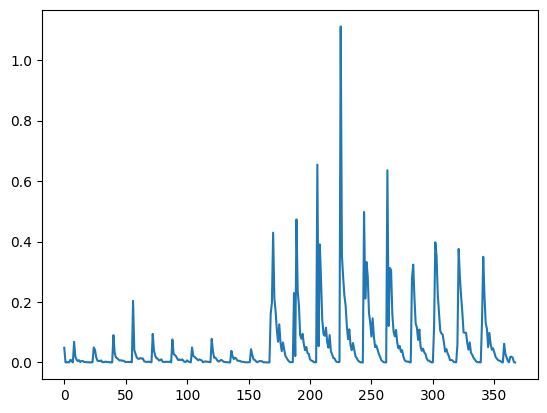

In [16]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[2,:])

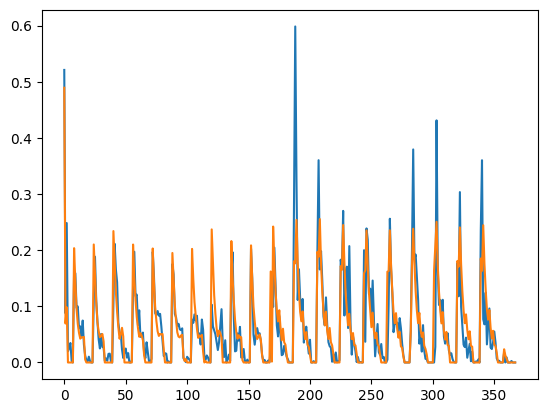

In [17]:
with torch.no_grad():
    fwd_output = engine.model((in_data, true_energy), True)
idx = 20
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:])

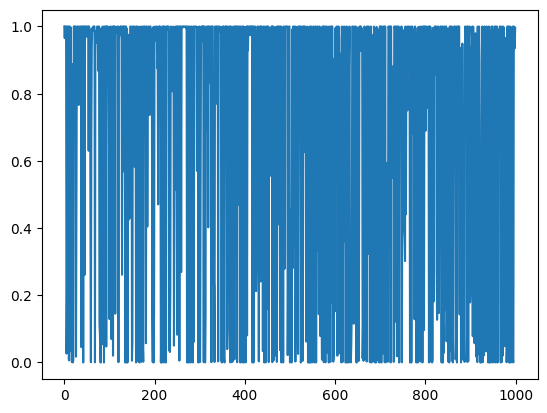

In [18]:
# enIn = torch.cat((in_data, true_energy), dim=1)
# beta, post_logits, post_samples = engine.model.encoder(enIn)
with torch.no_grad():
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
plt.plot(post_samples[0][0,:].detach().cpu().numpy())
post_samples = torch.cat(post_samples, 1)

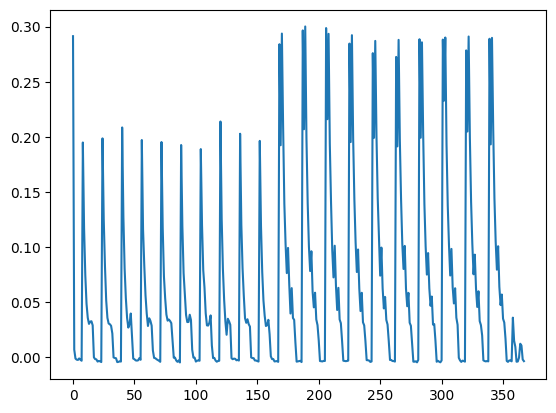

In [19]:
output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
plt.plot(output_activations[idx,:].detach().cpu().numpy())

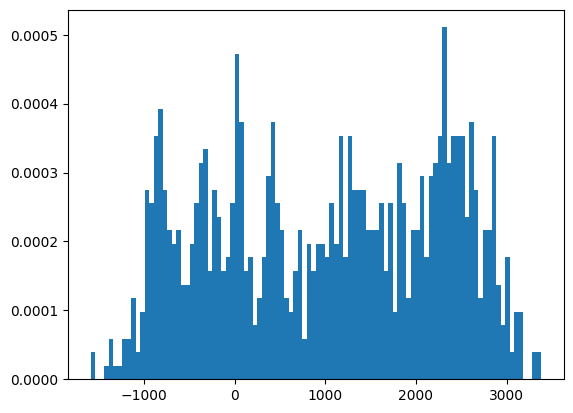

In [20]:
plt.hist(fwd_output.output_hits.sum(dim=1).detach().cpu().numpy(), bins=100, density=True)
# plt.hist(output_activations.sum(dim=1).detach().cpu().numpy(), bins=100, density=True)
plt.show()

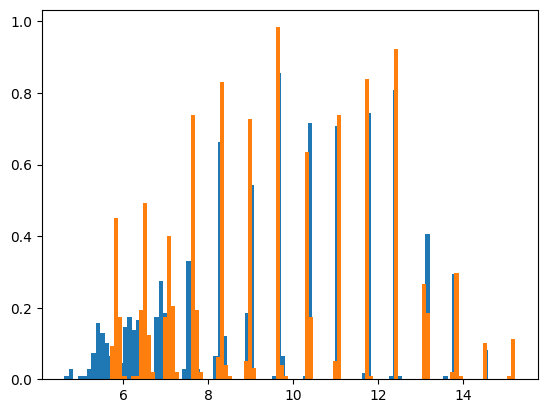

In [21]:
xhat = (output_activations.detach().exp() - 1)*0.04*true_energy
plt.hist(np.log(xx[0][0].sum(dim=1).cpu().numpy() + 1e-10), bins=100, density=True)
plt.hist(np.log(xhat.sum(dim=1).cpu().numpy() + 1e-10), bins=100, density=True)
plt.show()

In [22]:
en_labels = []
xtarget_samples = []
xrecon_samples = []
xitarget_samples = []
xirecon_samples = []
for xx in val_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    fwd_output = engine.model((in_data, true_energy), True)
    xVec = (fwd_output.output_activations.detach().exp() - 1)*0.04*true_energy
    
    xirecon_samples.append(fwd_output.output_activations.detach().cpu())
    xrecon_samples.append( xVec.detach().cpu() )
    
    xitarget_samples.append(in_data.detach().cpu())
    xtarget_samples.append( xx[0][0].detach().cpu() )
    
    en_labels.append(true_energy.detach().cpu())
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xitarget_samples = torch.cat(xitarget_samples, dim=0)  
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xirecon_samples = torch.cat(xirecon_samples, dim=0) 
en_labels = torch.cat(en_labels, dim=0)

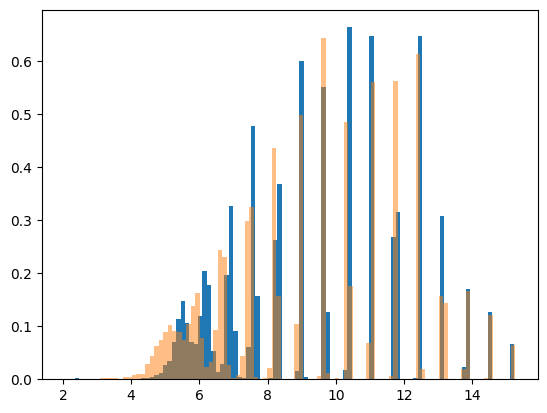

In [23]:
plt.hist(np.log(xtarget_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True)
plt.hist(np.log(xrecon_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.5)
plt.show()

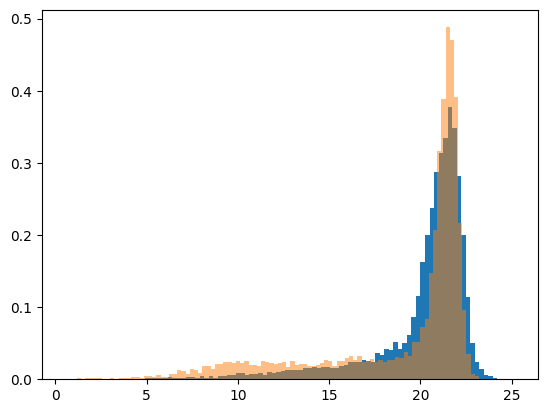

In [24]:
plt.hist(xitarget_samples.sum(dim=1).numpy(), bins=100, density=True)
plt.hist(xirecon_samples.sum(dim=1).numpy(), bins=100, density=True, alpha=0.5)
plt.show()

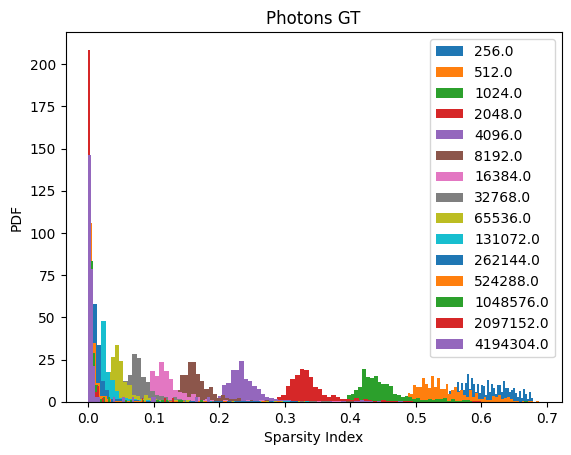

In [25]:
#Sparsity
for enIdx in en_labels.unique().numpy():
    idxBool = (en_labels == enIdx).nonzero(as_tuple=True)[0]
    xtargetTmp = xtarget_samples[idxBool,:]
    xreconTmp = xrecon_samples[idxBool, :]
    plt.hist(((xtargetTmp == 0).sum(dim=1)/533).numpy(), bins=50, density=True)
#     plt.hist(((xreconTmp == 0).sum(dim=1)/368).numpy(), bins=50, density=True, alpha=0.9)
plt.legend(list(en_labels.unique().numpy()))
plt.xlabel("Sparsity Index")
plt.ylabel("PDF")
plt.title("Photons GT")
plt.show()

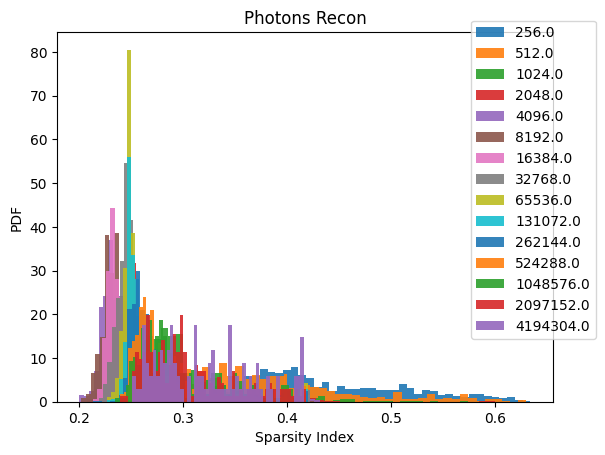

In [26]:
#Sparsity
for enIdx in en_labels.unique().numpy():
    idxBool = (en_labels == enIdx).nonzero(as_tuple=True)[0]
    xtargetTmp = xtarget_samples[idxBool,:]
    xreconTmp = xrecon_samples[idxBool, :]
#     plt.hist(((xtargetTmp == 0).sum(dim=1)/368).numpy(), bins=50, density=True)
    plt.hist(((xreconTmp == 0).sum(dim=1)/533).numpy(), bins=50, density=True, alpha=0.9)
plt.legend(list(en_labels.unique().numpy()), bbox_to_anchor=(1.1, 1.05))
plt.xlabel("Sparsity Index")
plt.ylabel("PDF")
plt.title("Photons Recon")
plt.show()

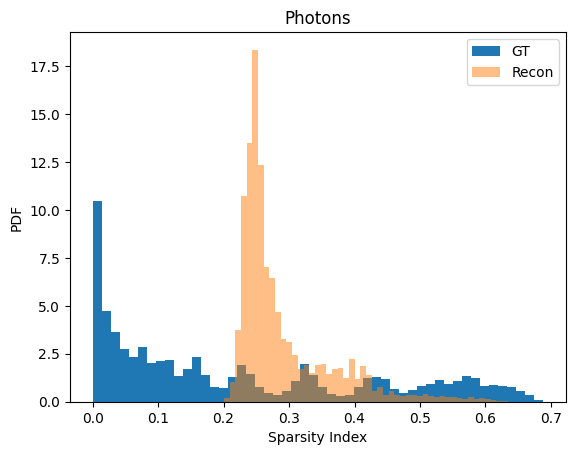

In [81]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/533).numpy(), bins=50, density=True)
plt.hist(((xrecon_samples == 0).sum(dim=1)/533).numpy(), bins=50, density=True, alpha=0.5)
plt.xlabel("Sparsity Index")
plt.ylabel("PDF")
plt.legend(["GT", "Recon"])
plt.title("Photons")
plt.show()

In [32]:
xitarget_samples.shape

torch.Size([12023, 533])

In [33]:
xihat_samples.shape

torch.Size([71680, 533])

In [41]:
# model.generate_samples(num_samples=1024, true_energy=0)

In [42]:
# sample_data

In [42]:
xhat_samples = []
xihat_samples = []
with torch.no_grad():
    for en in range(0,15):
        data_sampled = []
        for i in range(5):
            sample_energies, sample_data = model.generate_samples(num_samples=1024, true_energy=en)
            data_sampled.append(sample_data.detach().cpu())
        data_sampled = torch.cat(data_sampled, dim=0)
        xhat_samples.append((data_sampled.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),en))
        xihat_samples.append(data_sampled)
xhat_samples = torch.cat(xhat_samples, dim=0)
xihat_samples = torch.cat(xihat_samples, dim=0)

In [76]:
sam = []
for i in range(1):
    sample_energies, sample_data = model.generate_samples(num_samples=1000, true_energy=14)
    sam.append(sample_data.detach().cpu())
sam = torch.cat(sam, dim=0)

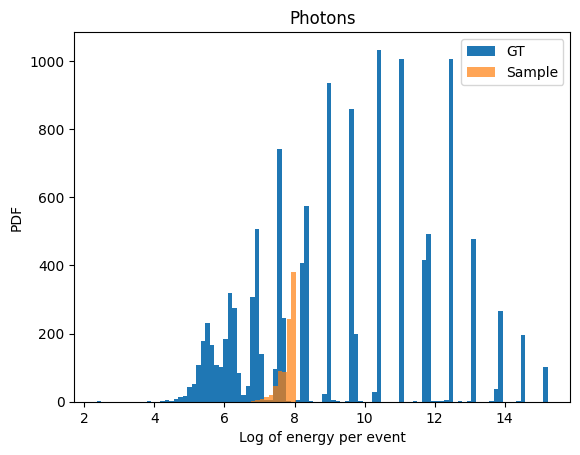

In [88]:
plt.hist(np.log(xtarget_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=False)
# plt.hist(np.log(xrecon_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.5)
# plt.hist(np.log(xhat_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.7)

sample_data_test = (sam.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),3.5)
plt.hist(np.log(sample_data_test.sum(dim=1).numpy() + 1e-10), bins=10, density=False, alpha=0.7)
plt.xlabel("Log of energy per event")
plt.ylabel("PDF")
plt.legend(["GT", "Sample"])
plt.title("Photons")
plt.show()

In [25]:
# xhat = (sample_data.detach().exp() - 1)*0.04*256*np.power(2,1)
# # plt.hist(xhat.sum(dim=1).cpu().numpy(), bins=100, density=True)
# plt.hist(np.log(xhat.sum(dim=1).cpu().numpy() + 1e-10), bins=100, density=True)
# plt.show()

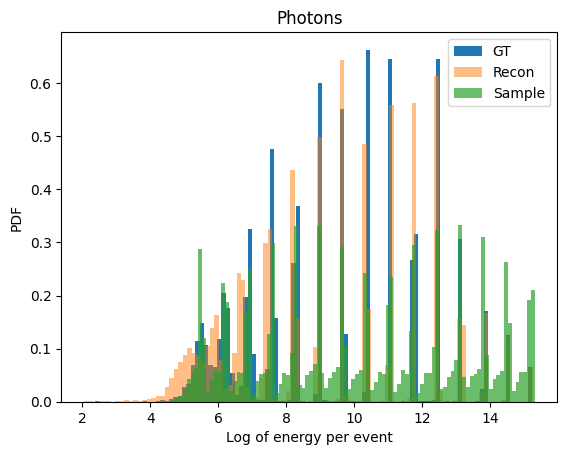

In [61]:
plt.hist(np.log(xtarget_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True)
plt.hist(np.log(xrecon_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.5)
plt.hist(np.log(xhat_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.7)

# sample_data_test = (sam.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),0)
# plt.hist(np.log(sample_data_test.sum(dim=1).numpy() + 1e-10), bins=10, density=False, alpha=0.7)
plt.xlabel("Log of energy per event")
plt.ylabel("PDF")
plt.legend(["GT", "Recon", "Sample"])
plt.title("Photons")
plt.show()

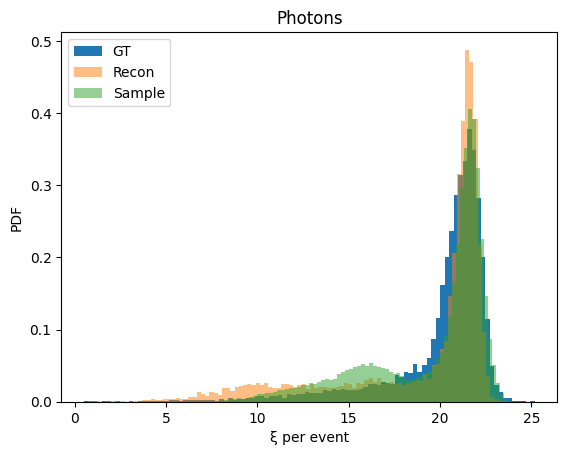

In [83]:
plt.hist(xitarget_samples.sum(dim=1).numpy(), bins=100, density=True)
plt.hist(xirecon_samples.sum(dim=1).numpy(), bins=100, density=True, alpha=0.5)
plt.hist(xihat_samples.sum(dim=1).numpy(), bins=100, density=True, alpha=0.5)
plt.xlabel("ξ per event")
plt.ylabel("PDF")
plt.legend(["GT", "Recon", "Sample"])
plt.title("Photons")
plt.show()

In [ ]:
# GT and Recon Comparison

In [55]:
sampDataAll, sampDataOutAll = np.array([]), np.array([])
for xx in val_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    fwd_output = engine.model((in_data, true_energy), True)
    
    sampDataAll = np.append(sampDataAll, np.sum(in_data.detach().cpu().numpy(), axis=1))
    sampDataOutAll = np.append(sampDataOutAll, np.sum(fwd_output.output_activations.detach().cpu().numpy(), axis=1))

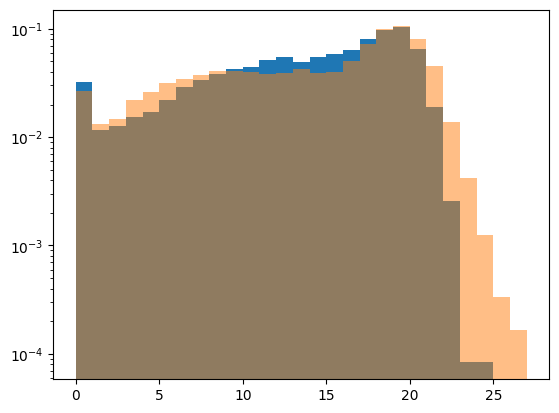

In [56]:
binwidth = 1

plt.hist(sampDataAll, bins=range(int(np.floor(min(sampDataAll))), int(np.ceil(max(sampDataAll))) + binwidth, binwidth), log=True, density=True)
plt.hist(sampDataOutAll, bins=range(int(np.floor(min(sampDataOutAll))), int(np.ceil(max(sampDataOutAll))) + binwidth, binwidth), log=True, density=True, alpha = 0.5)
plt.show()

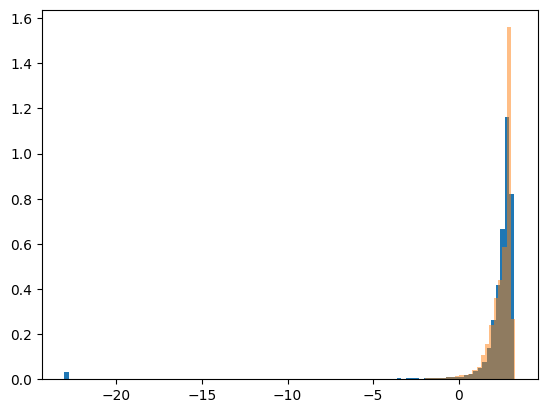

In [57]:
binwidth = 1
plt.hist(np.log(sampDataAll + 1e-10), bins=100, density=True)
plt.hist(np.log(sampDataOutAll + 1e-10), bins=100, density=True, alpha = 0.5)
plt.show()

In [33]:
# model

In [31]:
# model._hit_smoothing_dist_mod #(output_hits, beta, is_training)